In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
import xgboost as xgb

In [31]:
def generate_data(n_samples=1000, noise=0.4):
    np.random.seed(42)
    X = np.random.rand(n_samples, 5) * 10  
    y = (
        3 * np.sin(X[:, 0]) + 
        2 * np.log1p(X[:, 1]) + 
        1.5 * np.sqrt(X[:, 2]) - 
        2.5 * X[:, 3] + 
        0.8 * X[:, 4] + 
        noise * np.random.randn(n_samples)  
    )
    df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(1, 6)])
    df['Target'] = y
    return df

In [33]:
df = generate_data()
print("Dataset Preview:")
print(df.head())

Dataset Preview:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5    Target
0   3.745401   9.507143   7.319939   5.986585   1.560186 -6.898029
1   1.559945   0.580836   8.661761   6.011150   7.080726 -1.989055
2   0.205845   9.699099   8.324426   2.123391   1.818250  5.662548
3   1.834045   3.042422   5.247564   4.319450   2.912291  1.023069
4   6.118529   1.394939   2.921446   3.663618   4.560700 -1.476623


In [9]:
y = df['Target']
X = df.drop(columns=['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
baseline_rf = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
baseline_rf.fit(X_train, y_train)
y_pred_rf = baseline_rf.predict(X_test)

print("Random Forest Baseline Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))

Random Forest Baseline Model Performance:
MAE: 3.19518171017521
MSE: 14.854541171941994
R2 Score: 0.7535039305496315


In [39]:
# Gridsearch
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), 
param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
y_grid_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

print("Grid Search Tuned Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_grid_pred_rf))
print("MSE:", mean_squared_error(y_test, y_grid_pred_rf))
print("R2 Score:", r2_score(y_test, y_grid_pred_rf))

Grid Search Tuned Model Performance:
MAE: 1.530175655795297
MSE: 3.546202022532574
R2 Score: 0.9411543682222702


In [37]:
# Random Search
param_dist_rf = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(5, 50, 5),
    'min_samples_split': np.arange(2, 15, 2)
}
random_search_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), 
param_distributions=param_dist_rf, n_iter=10, cv=5, scoring='r2', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)
y_random_pred_rf = random_search_rf.best_estimator_.predict(X_test)

print("Random Tuned Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_random_pred_rf))
print("MSE:", mean_squared_error(y_test, y_random_pred_rf))
print("R2 Score:", r2_score(y_test, y_random_pred_rf))

Random Tuned Model Performance:
MAE: 1.5386655790258927
MSE: 3.589007006491372
R2 Score: 0.9404440628566181


In [23]:
# Bayesian Optimization
bayes_search_rf = BayesSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': (50, 300),
    'max_depth': (5, 50),
    'min_samples_split': (2, 15)
}, n_iter=10, cv=5, scoring='r2', n_jobs=-1, random_state=42)
bayes_search_rf.fit(X_train, y_train)
y_bayes_pred_rf = bayes_search_rf.best_estimator_.predict(X_test)

print("Bayesian Tuned Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_bayes_pred_rf))
print("MSE:", mean_squared_error(y_test, y_bayes_pred_rf))
print("R2 Score:", r2_score(y_test, y_bayes_pred_rf))

Bayesian Tuned Model Performance:
MAE: 1.5392397007044532
MSE: 3.5838682872144916
R2 Score: 0.9405293346996927


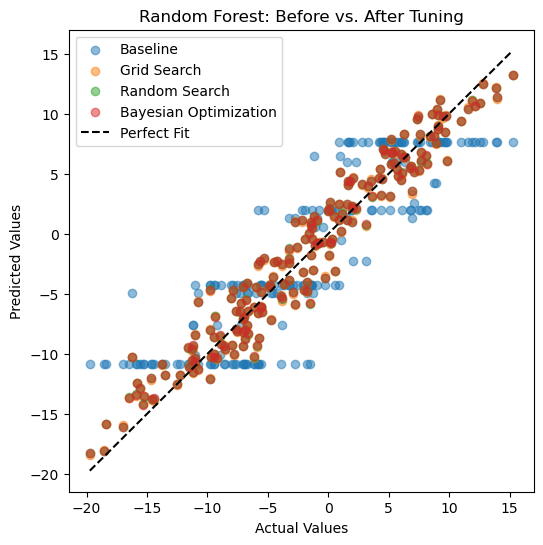

In [41]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Baseline')
plt.scatter(y_test, y_grid_pred_rf, alpha=0.5, label='Grid Search')
plt.scatter(y_test, y_random_pred_rf, alpha=0.5, label='Random Search')
plt.scatter(y_test, y_bayes_pred_rf, alpha=0.5, label='Bayesian Optimization')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Perfect Fit')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Before vs. After Tuning")
plt.legend()
plt.show()